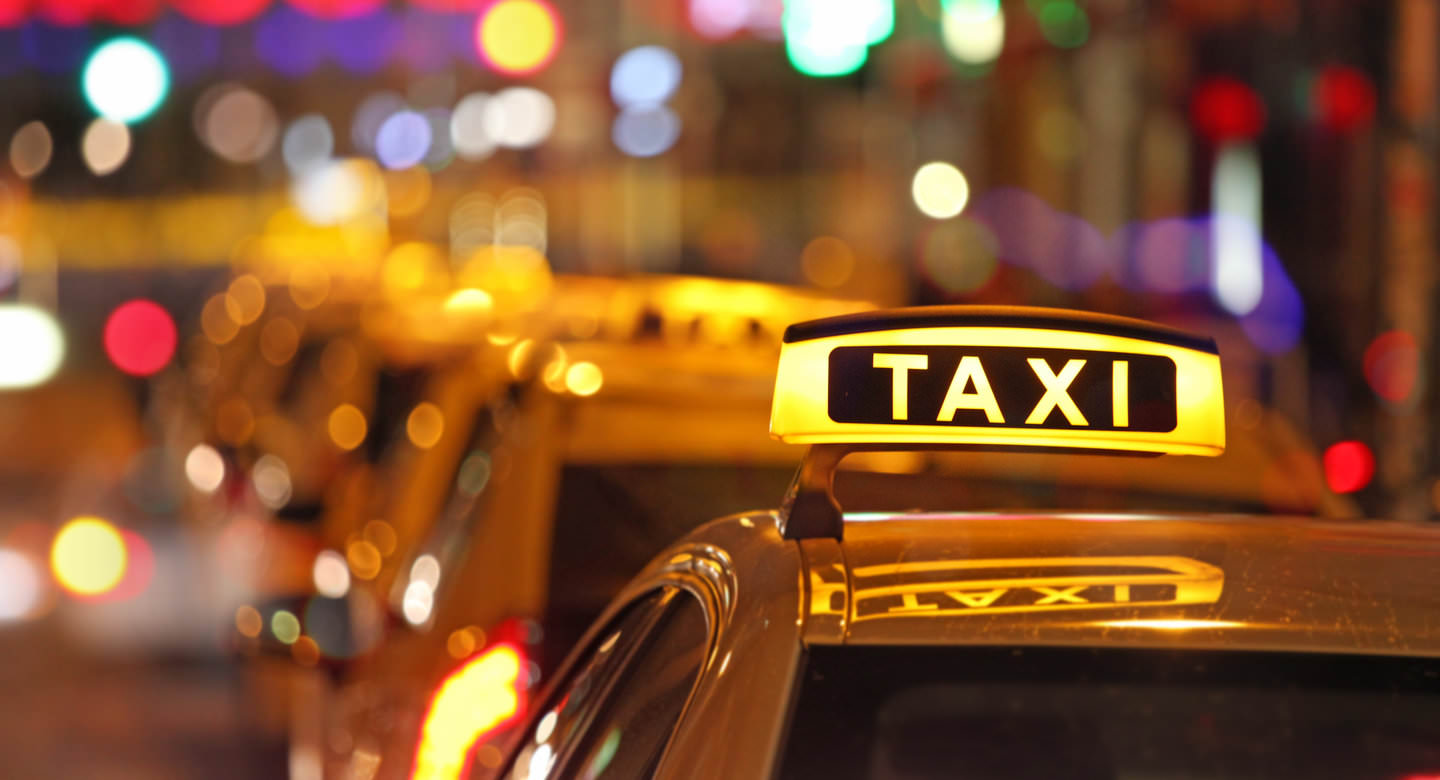


# Objective

- Develop a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables


## Task:
- Investigate the variables that influence the duration of the trip.
- Based on individual trip attributes, predict the duration of each trip in the test set.
- Other additional analysis

## Data source (stage 1):

- Taxi trip data provided

## Data source (stage 2, future work)
- External data soruce - Weather data in NYC
- External data source - OSRM data in NYC

## Data field

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds


## 1) import the necessary package

In [67]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import datetime as dt

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

import xgboost as xgb
from sklearn.metrics import explained_variance_score

import lightgbm as lgb
import joblib
import gmplot 


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]



In [2]:
## read input data
train = pd.read_csv('nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('nyc-taxi-trip-duration/test.csv')
sample_submission = pd.read_csv('nyc-taxi-trip-duration/sample_submission.csv')

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [17]:
## check null value

train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

- good to know there is no null or missing value in the dataset

In [13]:
## statistic summary

train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [15]:
## show column data type info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


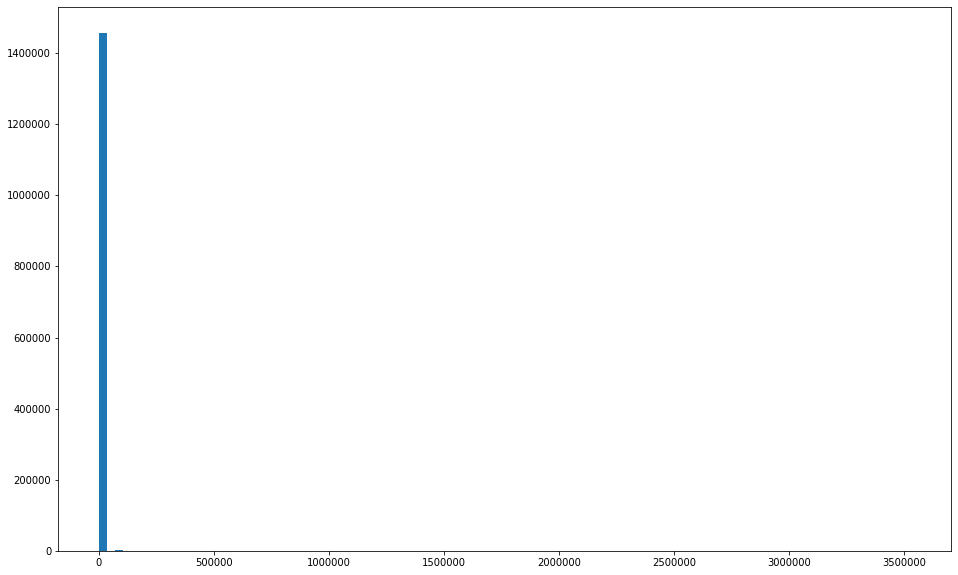

In [24]:
## plot histogram
plt.hist(train['trip_duration'].values, bins=100)
plt.show()

The trip duration have a huge range of number (from 1 seconds to 3,526,282 seconds ( or 977 hours), lets do some log transformation



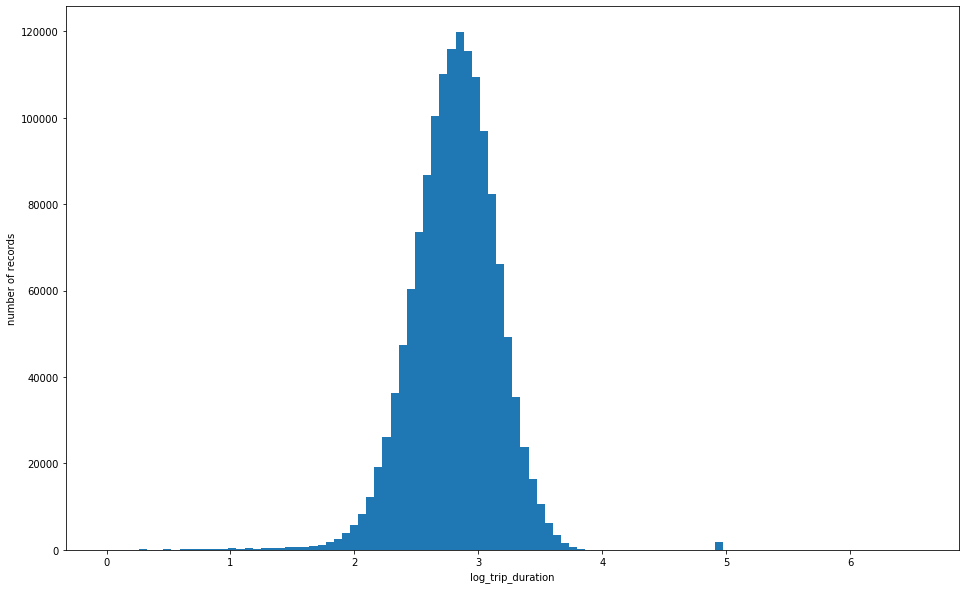

In [42]:
## apply log10 transformation
train['log_trip_duration'] = np.log10(train['trip_duration'].values)

plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log_trip_duration')
plt.ylabel('number of records')
plt.show()

we can see the distrubtion center at log10 = 3, which is 1000 seconds or 16.7 minutes in average per trip 

## extract additional date & time feature

In [ ]:
## change to proper date data format 
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

In [5]:
# extract Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

## extract day of the month
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day

## extarct day of week
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

## extract hour
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour


## 2) exploratory data analysis

### 2.1 number of trips over the time

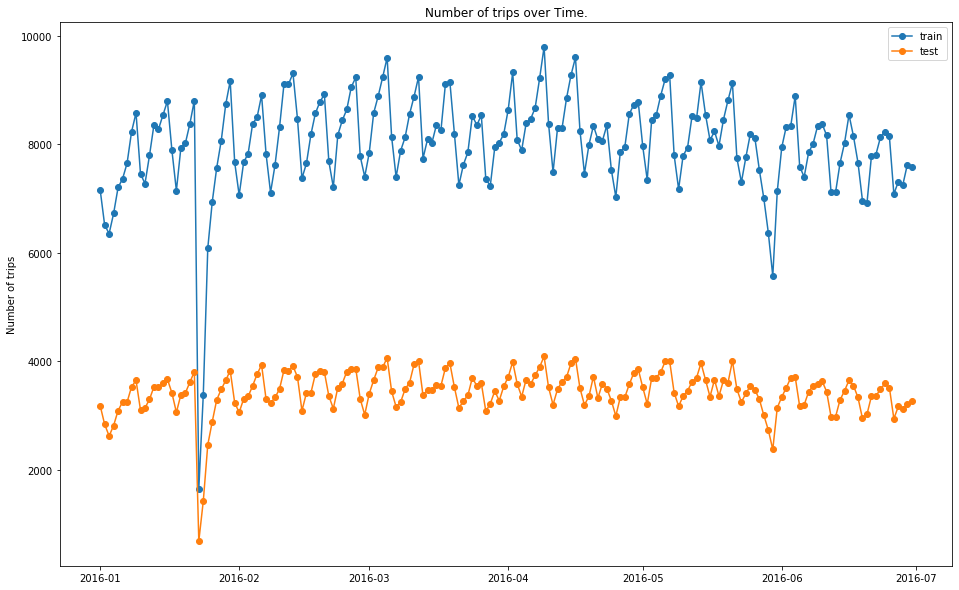

In [9]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Number of trips over Time.')
plt.legend(loc=0)
plt.ylabel('Number of trips')
plt.show()

Both train and test data follow the same pattern over the time. There are some interesting point

- In late Jan 2016, there are sharp fall on the trips number, it could be relate to winter season or festival. However it happen to short period, it might be worth noting on this discrepancy, perhaps it might be caused by data system error or other factor 

## 2.2 pick up location map visualization

In [35]:
## mean value of coordinate
train.pickup_latitude.mean() , train.pickup_longitude.mean()



(40.750920908391734, -73.97348630489282)

In [43]:
# Store our latitude and longitude
latitudes = train.pickup_latitude[:10000]  ## take n sample
longitudes = train.pickup_longitude[:10000]

# Creating the location we would like to initialize the focus on. 
# Parameters: Lattitude, Longitude, Zoom

gmap = gmplot.GoogleMapPlotter(train.pickup_latitude.mean() , train.pickup_longitude.mean() , 10)


# Overlay our datapoints onto the map
gmap.heatmap(latitudes, longitudes)

# Generate the heatmap into an HTML file
gmap.draw("my_heatmap_10k_train.html")

In [42]:
from IPython.display import IFrame

IFrame(src='my_heatmap_10k_train.html', width=700, height=300)

from the map above, it show pick-up location with density are:
- new york city 
- John Kennedy international airport
- La Guardia airport

In [44]:
# Store our latitude and longitude
latitudes = test.pickup_latitude[:10000]  ## take n sample
longitudes = test.pickup_longitude[:10000]

# Creating the location we would like to initialize the focus on. 
# Parameters: Lattitude, Longitude, Zoom

gmap = gmplot.GoogleMapPlotter(test.pickup_latitude.mean() , test.pickup_longitude.mean() , 10)


# Overlay our datapoints onto the map
gmap.heatmap(latitudes, longitudes)

# Generate the heatmap into an HTML file
gmap.draw("my_heatmap_10k_test.html")

In [45]:
IFrame(src='my_heatmap_10k_test.html', width=700, height=300)

the same go to test data set, the pick up density look similar with the train dataset

## 2.3 Function to calculate distance ( from the pick-up to drop-off pont) & direction

### Haversine distance

The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

Formula:
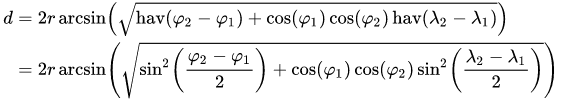

reference: https://en.wikipedia.org/wiki/Haversine_formula


- First we calculate haversine distance, which is the great-circle distance between two points on a sphere given their longitudes and latitudes.

- then we calculate the summed distance traveled in Manhattan. 

- Finally we calculate the direction (or bearing) of the distance traveled using trigonmetry


In [10]:

## calculate distance using haversine and manhattan distance

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km, default value
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [11]:
## pick-up location
train_lat1 = train['pickup_latitude'].values
train_lng1 = train['pickup_longitude'].values
test_lat1 = test['pickup_latitude'].values
test_lng1 = test['pickup_longitude'].values

## drop-off coordinate
train_lat2 = train['dropoff_latitude'].values
train_lng2 =  train['dropoff_longitude'].values
test_lat2 = test['dropoff_latitude'].values
test_lng2 = test['dropoff_longitude'].values

## apply distance calculation
train.loc[:, 'distance_haversine'] = haversine_array( train_lat1, train_lng1 , train_lat2 , train_lng2)
test.loc[:, 'distance_haversine'] = haversine_array( test_lat1, test_lng1 , test_lat2 , test_lng2)
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train_lat1, train_lng1 , train_lat2 , train_lng2)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance( test_lat1, test_lng1 , test_lat2 , test_lng2)
    
    
train.loc[:, 'direction'] = bearing_array(train_lat1, train_lng1 , train_lat2 , train_lng2)
test.loc[:, 'direction'] = bearing_array( test_lat1, test_lng1 , test_lat2 , test_lng2)

In [56]:
train['distance_haversine'].describe()

count    1.458644e+06
mean     3.440864e+00
std      4.296538e+00
min      0.000000e+00
25%      1.231837e+00
50%      2.093717e+00
75%      3.875337e+00
max      1.240909e+03
Name: distance_haversine, dtype: float64

## 2.3b  Function to calculate speed of travel

In [121]:
## apply speed function ( speed = total distance / duration )
train.loc[:, 'avg_speed_h'] = train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = train['distance_dummy_manhattan'] / train['trip_duration']

## apply speed function ( speed = total distance / duration )
test.loc[:, 'avg_speed_h'] = test['distance_haversine'] / train['trip_duration']
test.loc[:, 'avg_speed_m'] = test['distance_dummy_manhattan'] / train['trip_duration']

## 2.4 explore categorical variable

In [12]:
## selected categorical variable
cat_columns= [ 'vendor_id', 'store_and_fwd_flag', 'Month', 'DayofMonth', 'dayofweek', 'Hour' ]

## change data-type to category for further processing
train[cat_columns] = train[cat_columns].astype('category')

test[cat_columns] = test[cat_columns].astype('category')

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 17 columns):
id                          625134 non-null object
vendor_id                   625134 non-null category
pickup_datetime             625134 non-null datetime64[ns]
passenger_count             625134 non-null int64
pickup_longitude            625134 non-null float64
pickup_latitude             625134 non-null float64
dropoff_longitude           625134 non-null float64
dropoff_latitude            625134 non-null float64
store_and_fwd_flag          625134 non-null category
pickup_date                 625134 non-null object
Month                       625134 non-null category
DayofMonth                  625134 non-null category
dayofweek                   625134 non-null category
Hour                        625134 non-null category
distance_haversine          625134 non-null float64
distance_dummy_manhattan    625134 non-null float64
direction                   625134 non-null floa

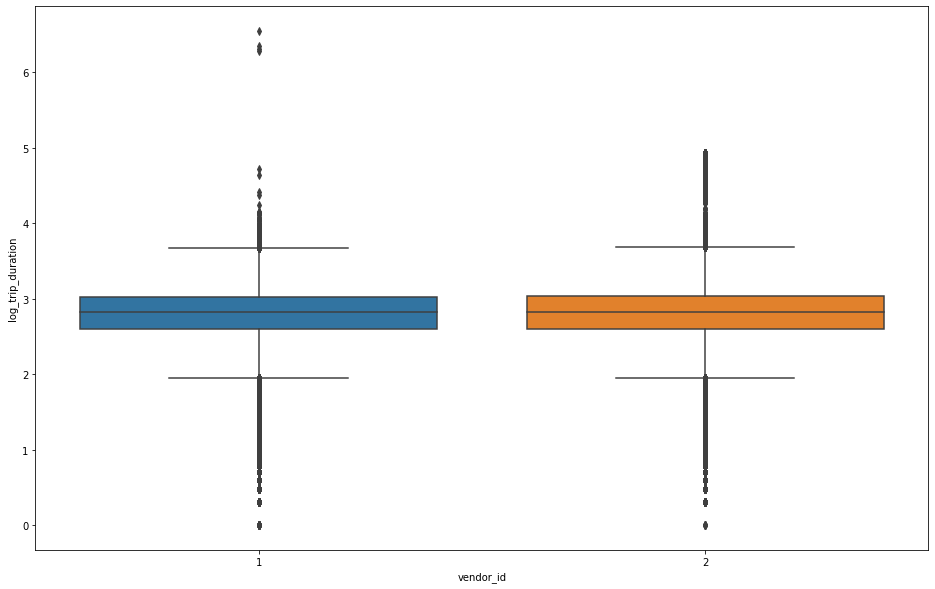

In [14]:
## box plot
sns.boxplot(x='vendor_id',y='log_trip_duration',data=train)


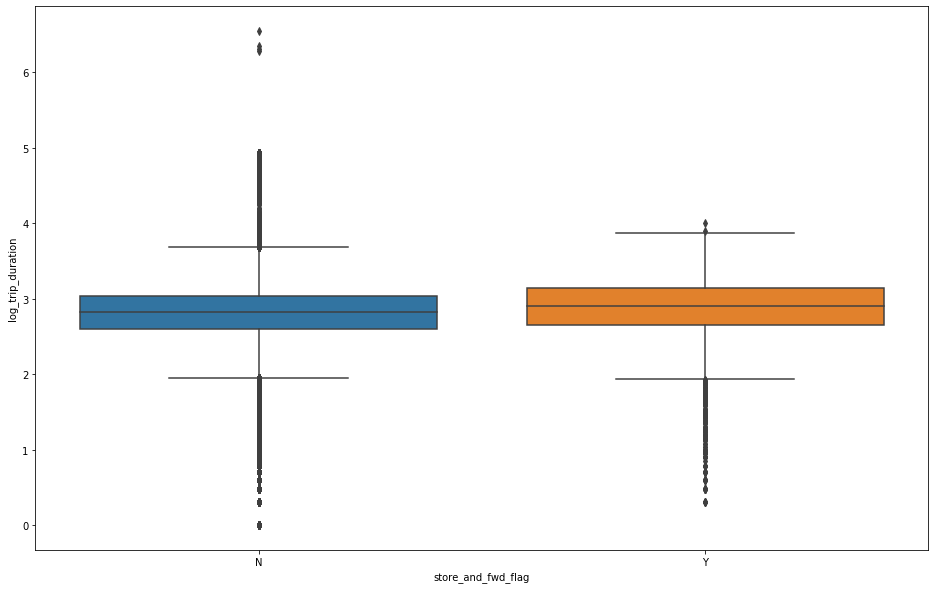

In [15]:
sns.boxplot(x='store_and_fwd_flag',y='log_trip_duration',data=train)


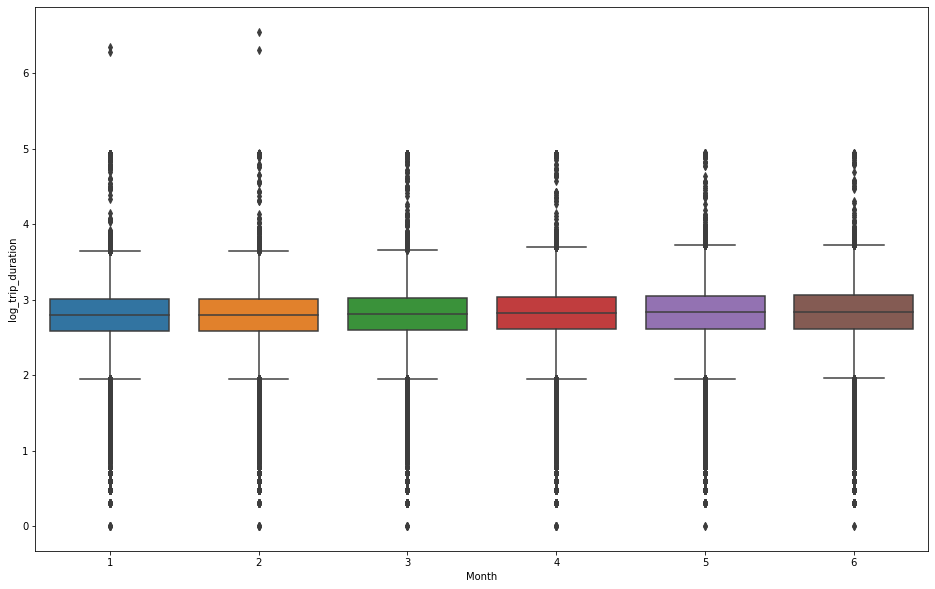

In [16]:
sns.boxplot(x='Month',y='log_trip_duration',data=train)


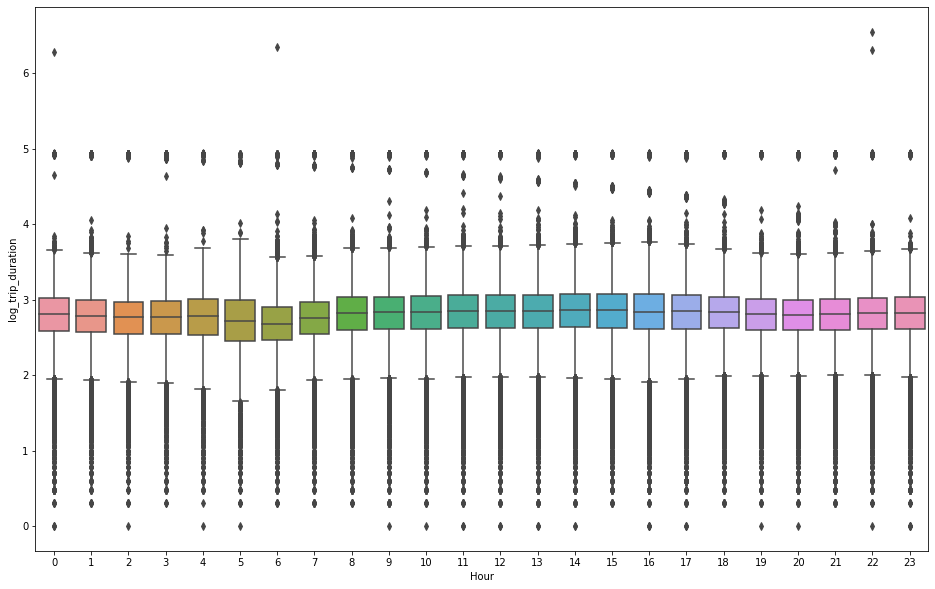

In [17]:
sns.boxplot(x='Hour',y='log_trip_duration',data=train)


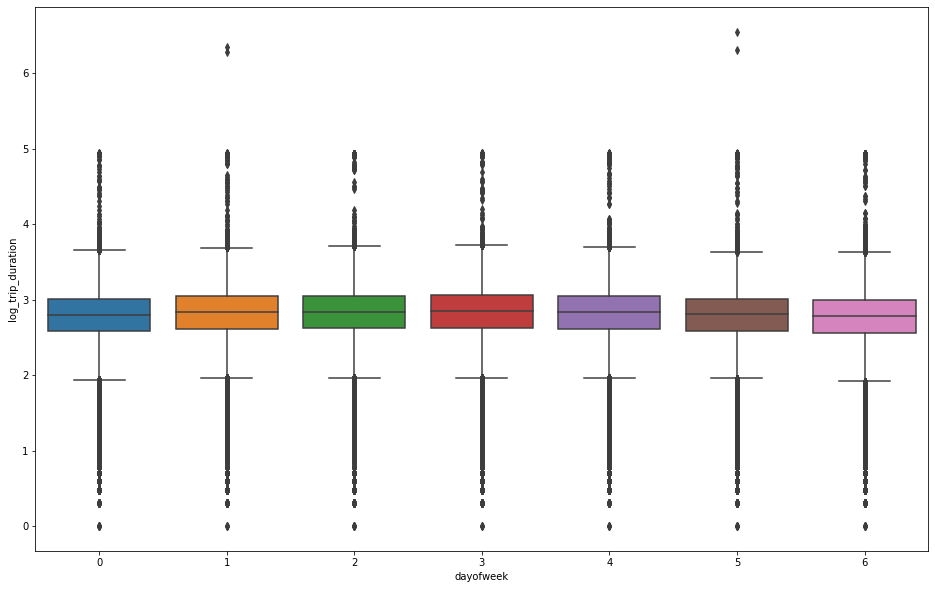

In [18]:
sns.boxplot(x='dayofweek',y='log_trip_duration',data=train)


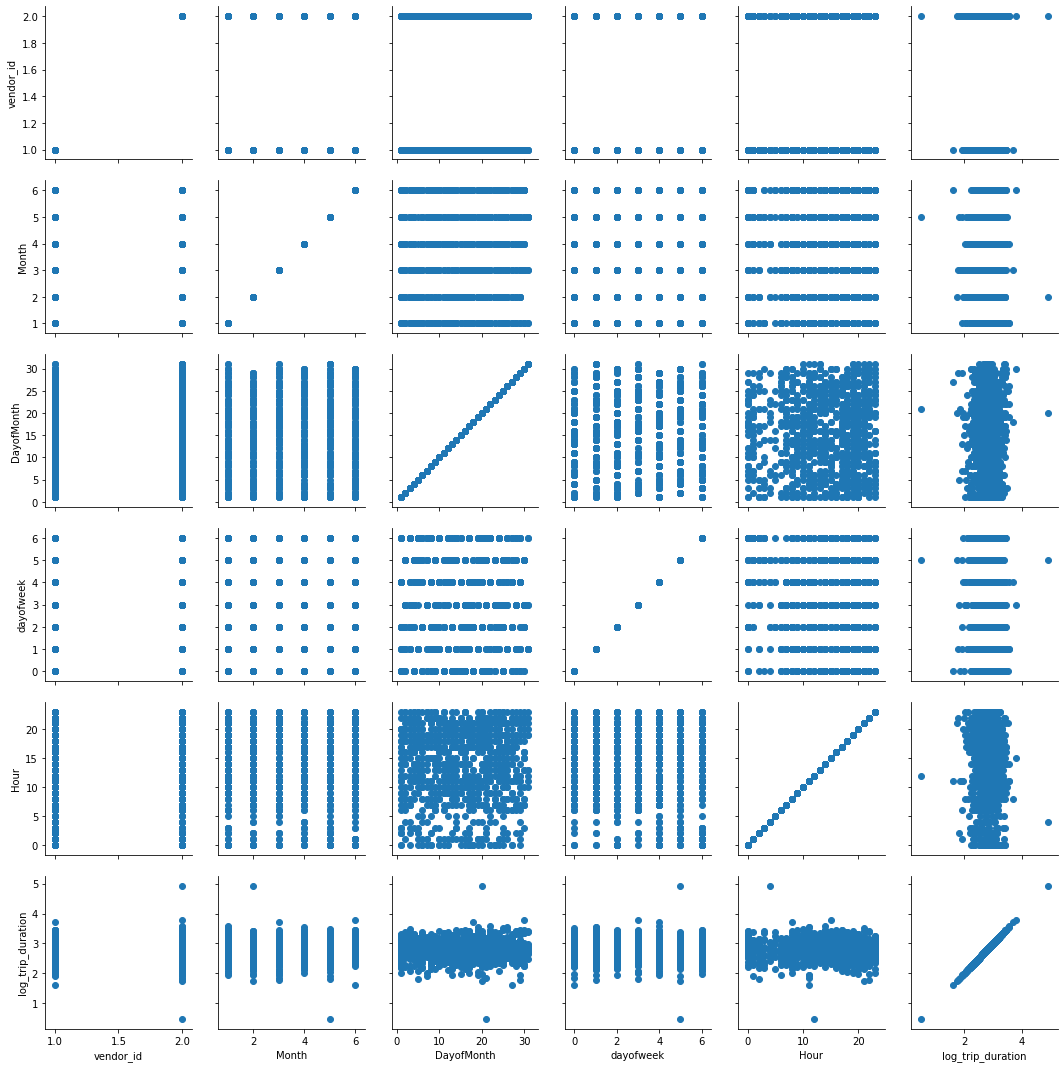

In [73]:

### sns pairplot to visualize all variable

# selected_df = train[ ['vendor_id', 'store_and_fwd_flag', 'Month', 'DayofMonth', 'dayofweek', 'Hour','log_trip_duration'] ]

# g = sns.PairGrid( selected_df[:1000])
# g.map(plt.scatter);

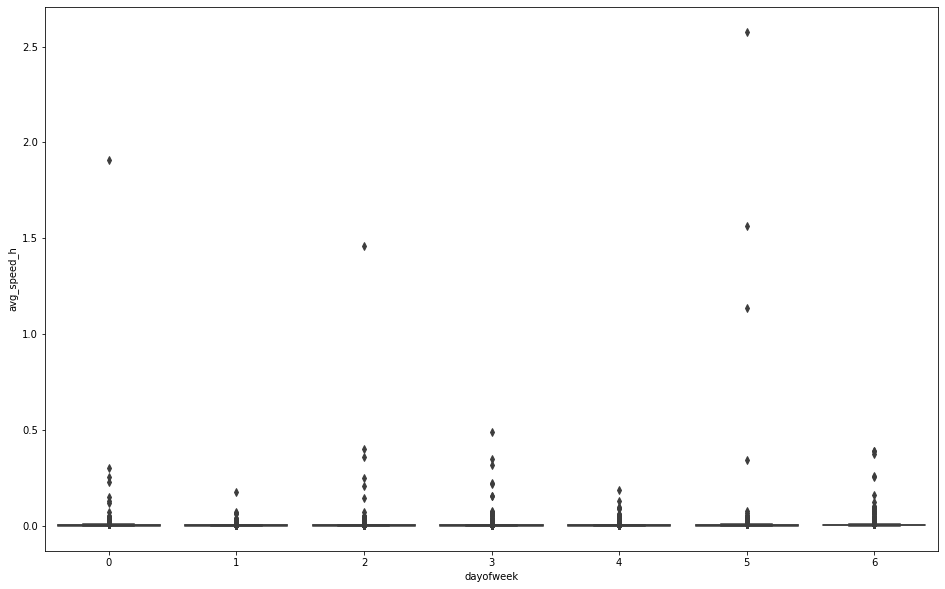

In [28]:
sns.boxplot(x='dayofweek',y='avg_speed_h',data=train)


### 3.1 Data enhancement + create dummy variable for categorical variable

In [96]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'pickup_date', 'Month',
       'DayofMonth', 'dayofweek', 'Hour', 'distance_haversine',
       'distance_dummy_manhattan', 'direction'],
      dtype='object')

In [19]:
## create dummy data
train_cat_dummy = pd.get_dummies(train[cat_columns], prefix_sep='_')

test_cat_dummy = pd.get_dummies(test[cat_columns], prefix_sep='_')

In [128]:
train_cat_dummy

,vendor_id_1,vendor_id_2,store_and_fwd_flag_N,store_and_fwd_flag_Y,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,0,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1458640,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1458641,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1458642,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [129]:
test_cat_dummy

,vendor_id_1,vendor_id_2,store_and_fwd_flag_N,store_and_fwd_flag_Y,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625130,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625131,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625132,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:

## select variable from original data and merge with categorical dummy data
train_master = train[['log_trip_duration', 'distance_dummy_manhattan','distance_haversine','direction']] .join(train_cat_dummy)
test_master = test[['distance_dummy_manhattan','distance_haversine','direction']].join(test_cat_dummy)



In [139]:
train_master.shape

(1458644, 76)

In [140]:
test_master.shape

(625134, 75)

In [133]:
test_master.head()

,distance_dummy_manhattan,distance_haversine,direction,vendor_id_1,vendor_id_2,store_and_fwd_flag_N,store_and_fwd_flag_Y,Month_1,Month_2,Month_3,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,2.913304,2.746426,-3.595224,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3.104805,2.759239,172.278835,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.846340,1.306155,133.326248,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,7.163347,5.269088,-150.956833,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1.354164,0.960842,130.260381,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 3.2  prepare train test data

In [141]:

X = train_master.drop(['log_trip_duration'],axis=1)
y = train_master['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1166915, 75) (291729, 75)


## 4.1  Model 1 - XGboost

In [151]:
## create specific train matrix dataset for xgboost and with n samples

n_samples = 1166915 ## all training samples
data_train  = xgb.DMatrix (X_train[:n_samples], label=y_train[:n_samples] )
data_test  = xgb.DMatrix( X_test[:n_samples]   , label=y_test[:n_samples] )
eval_list = [(data_train, 'train'), (data_test, 'test')]


In [152]:
xgb_params = {'max_depth':8, # maximum depth of a tree
             'objective':'reg:linear', ## linear objective function
             'eta'      :0.3, # learning rate 
             'lambda '  :4,   #L2 regularization term, suggest >1 more conservative 
             'colsample_bytree ':0.8,
             'colsample_bylevel':1,
             'min_child_weight': 10, 
             'subsample':0.8, # subsample percentage of data
             'nthread'  :4}  #number of cpu core

## build xgboost model
xgb_model = xgb.train(xgb_params, data_train, num_boost_round=200, evals = eval_list,
                  early_stopping_rounds=30, maximize=False)

print('score = %1.4f, n_boost_round =%d.'  %(xgb_model.best_score ,  xgb_model.best_iteration) )

[13:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:1.64021	test-rmse:1.64089
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 30 rounds.
[1]	train-rmse:1.15767	test-rmse:1.15834
[2]	train-rmse:0.82353	test-rmse:0.82423
[3]	train-rmse:0.59456	test-rmse:0.59536
[4]	train-rmse:0.44057	test-rmse:0.44151
[5]	train-rmse:0.34008	test-rmse:0.34116
[6]	train-rmse:0.27718	test-rm

In [188]:
xgb_predictions = xgb_model.predict( xgb.DMatrix(X_test) )
xgb_predictions

array([2.9024563, 2.6671374, 2.650149 , ..., 2.8730233, 2.9449778,
       3.1451437], dtype=float32)

In [191]:
## mean absolute error
mae = metrics.mean_absolute_error(y_test,xgb_predictions )
print( "Xgboost model -  Mean absolute error:", mae)

## mean squared error
rmse = sqrt(mean_squared_error(y_test, xgb_predictions))
print( "Xgboost model - RMSE:", rmse)


Xgboost model -  Mean absolute error: 0.12510858820486426
Xgboost model - RMSE: 0.19022938922604163


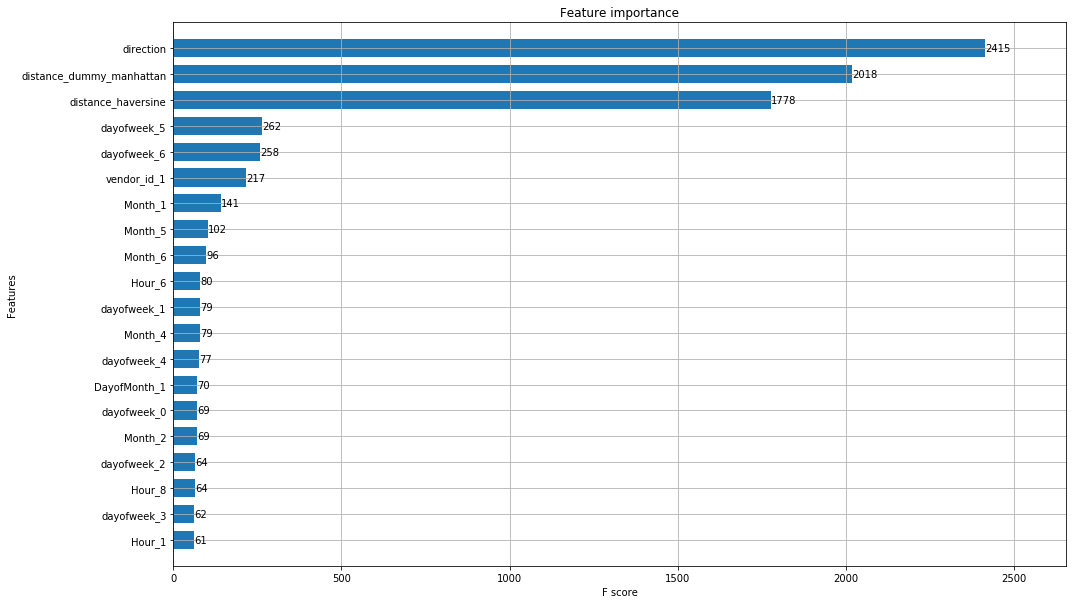

In [185]:
## xgb variable importance plot

xgb.plot_importance( xgb_model, max_num_features=20, height=0.7)


### model finding
- direction & distance (haversine and manhatan) show high importance variable
- dayofweek_5 and dayofweek_6 refer to saturday and sunday, also a contributing factor the trip duration


In [195]:
# save the model to disk
filename = 'model/kim_xgboost.sav'
joblib.dump( xgb_model , filename)
 

['model/kim_xgboost.sav']

### apply xgboost model to actual kaggle test data

In [199]:
## make prediction
xgb_model_predictions = xgb_model.predict(  xgb.DMatrix(test_master))

## apply exponential transform to obtain actual duration

actual_predictions = 10**xgb_model_predictions


In [200]:
## create submission result
xgb_submission = pd.concat([test['id'], pd.DataFrame(actual_predictions)], axis=1)
xgb_submission.columns = ['id','trip_duration']

In [201]:
xgb_submission.head()

,id,trip_duration
0,id3004672,765.924194
1,id3505355,860.649597
2,id1217141,440.244476
3,id2150126,1115.612183
4,id1598245,345.490173


In [202]:
## save to csv file
xgb_submission.to_csv("kim_submission_xgb_v3.csv", index=False)

# 4.2  Model 2 - Light GBM

In [177]:

## create model-specific train data matrix

n_samples = 1166915 ## all training samples
data_train  = lgb.Dataset (X_train[:n_samples], label=y_train[:n_samples] )
data_test  = lgb.Dataset( X_test[:n_samples]   , label=y_test[:n_samples] )
eval_list = [(data_train, 'train'), (data_test, 'test')]


## define parameter
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'max_depth': 8, 
    'learning_rate': 0.05,
    'verbose': 10} 

## number of estimators
n_estimators = 500


## model 
lightgbm_model = lgb.train(params, data_train, n_estimators,  verbose_eval=1)


In [178]:

## model prediction
lgb_predictions = lightgbm_model.predict(X_test)
lgb_predictions


array([2.883844  , 2.69877376, 2.64137215, ..., 2.87674594, 2.92810968,
       3.15596242])

In [186]:
## mean absolute error
mae = metrics.mean_absolute_error(y_test,lgb_predictions )
print( "Light GBM model - Mean absolute error:", mae)

## mean squared error
rmse = sqrt(mean_squared_error(y_test, lgb_predictions))
print( "Light GBM model -  RMSE:", rmse)

Light GBM model - Mean absolute error: 0.12507887256006323
Light GBM model -  RMSE: 0.19008778244166386


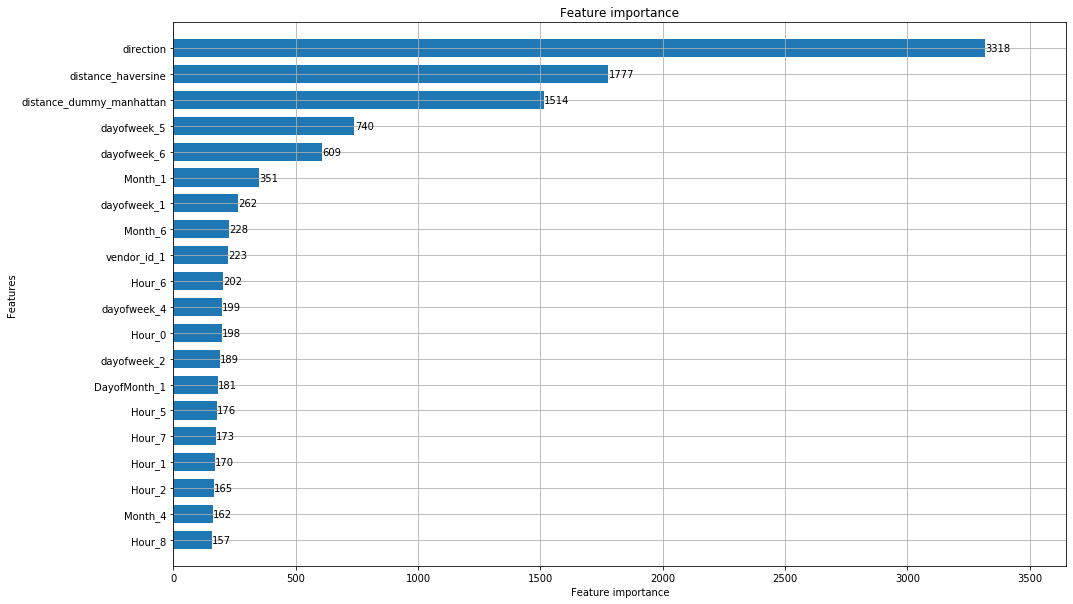

In [194]:
## lgb variable importance plot
lgb.plot_importance( lightgbm_model, max_num_features=20, height=0.7)


### model finding

the light-gbm model importance are similar to Xgboost 
- direction & distance (haversine and manhatan) show high importance variable
- dayofweek_5 and dayofweek_6 refer to saturday and sunday, also a contributing factor the trip duration


In [197]:
# save the model to disk
filename = 'model/kim_lightgbm.sav'
joblib.dump( lightgbm_model , filename)
 

['model/kim_lightgbm.sav']

## apply light-gbm model on test master data

In [180]:
## make prediction
predictions = lightgbm_model.predict(test_master)

## apply exponential transform to obtain actual duration

actual_predictions = 10**predictions




In [181]:
## create submission result
lgb_submission = pd.concat([test['id'], pd.DataFrame(actual_predictions)], axis=1)
lgb_submission.columns = ['id','trip_duration']


In [182]:
lgb_submission.head()

,id,trip_duration
0,id3004672,739.130932
1,id3505355,830.328913
2,id1217141,444.431504
3,id2150126,1088.829916
4,id1598245,342.310908


In [183]:
## save to csv file
lgb_submission.to_csv("kim_submission_lightgbm_v3.csv", index=False)

# 5. summary and finding

Based on the current stage data source, tested two popular gradient boosting model( Xgboost and Light-gbm) using feature based on dateTime and distance ( haversine & manhanttan)


### Model performance ( log10 of trip duration (seconds) )
- Xgboost model - RMSE: 0.19023
- Light GBM model -  RMSE: 0.1901


### Model importance:
- Both xgboost and light-gbm show similar importance plot where:
    - Direction & distance (haversine and manhatan) show high importance variable
    - dayofweek_5 and dayofweek_6 refer to saturday and sunday (weekend), also a contributing factor the trip duration. As we know normally weekend will have higher traffic as compare to weekday
    
- the calculated average speed (total distance/ trip duration) not giving a good model performance and has been excluded from submission, further investigation needed 


### Actual score at kaggle competition

- Xgboost model give the best score = 0.43956, which ranked around 600th out of 1500 at public leaderboard
- Light-GBM model score = 0.4462

----  

### Stage 2 and Future work
- explore additional dataset such as weather and OSRM dataset
- feature engineering (add in more location-based feature such as location cluster, traffic density, weather and visibility and other

- model cross-validation
